<a href="https://colab.research.google.com/github/Chtholly000/simplified-cnn-fer/blob/main/Model_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


All libraries imported successfully.
CK+ Data preprocessing class and transforms for CSV are defined.
CNN Model 1 class is defined.
Using device: cuda
Filtered out 18 rows with invalid emotion labels.

Successfully loaded CK+ dataset.
Original training set size: 721
Augmented training set size: 7210
Validation set size: 181
Loss function: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.001
    lr: 0.001
    maximize: False
    weight_decay: 1e-05
)
Scheduler: StepLR

--- Starting Training for Model 1 on CK+ ---
Epoch [001/120], Train Loss: 0.8349, Val Loss: 0.4360, Val Accuracy: 87.29%
Epoch [002/120], Train Loss: 0.2767, Val Loss: 0.3195, Val Accuracy: 91.16%
Epoch [003/120], Train Loss: 0.1572, Val Loss: 0.4893, Val Accuracy: 92.27%
Epoch [004/120], Train Loss: 0.0947, Val Loss: 0.5630, Val Accuracy: 90.61%
Epoch [005/120

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


--- Plotting Training History ---


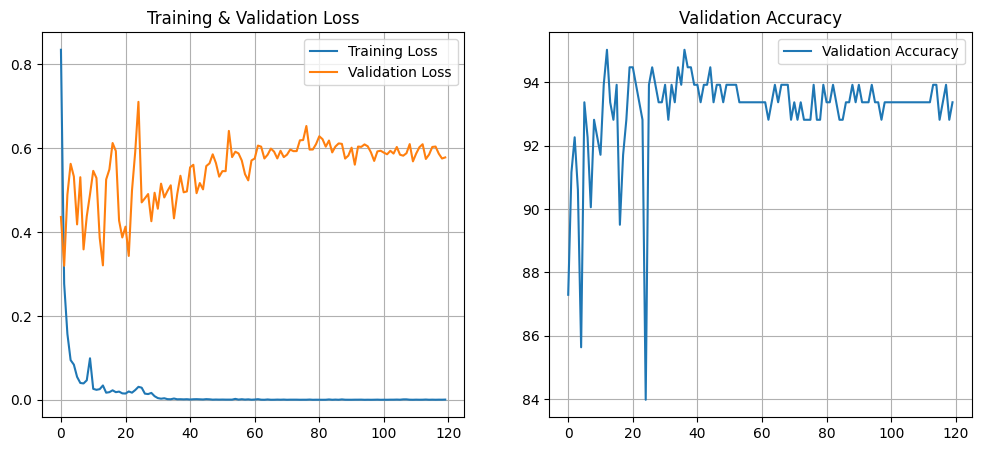


--- Visualizing Model 1 Predictions ---


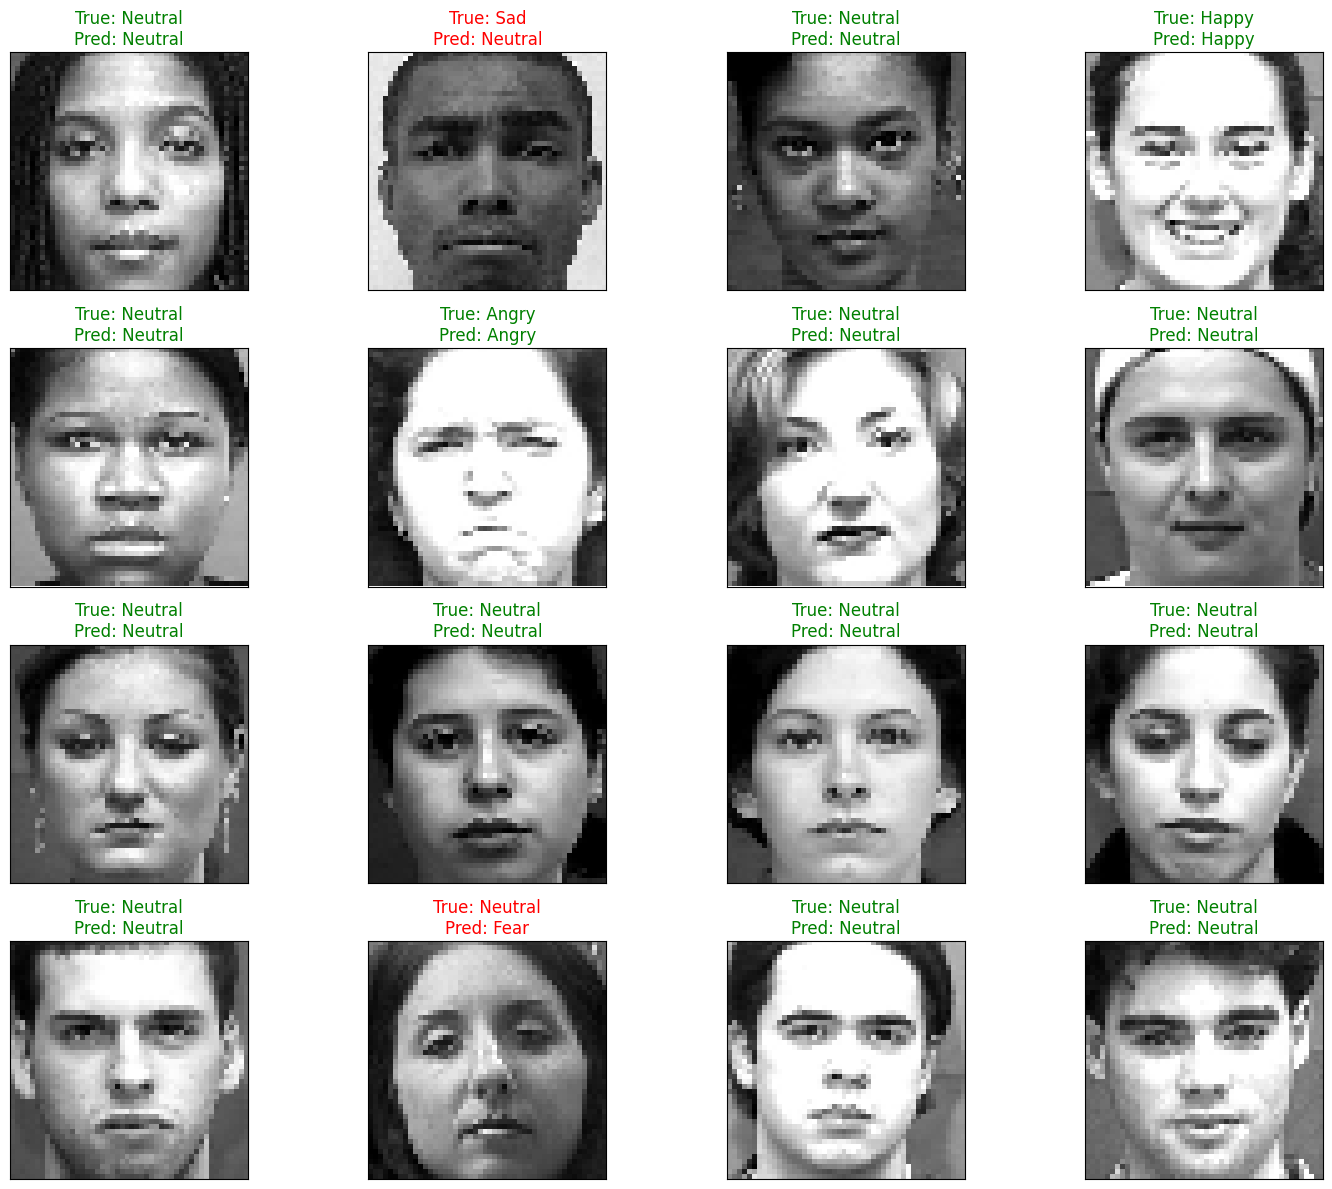

In [3]:
# ==============================================================================
# PART 1: IMPORTS AND SETUP
# ==============================================================================
import os
import pandas as pd
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from google.colab import files

print("All libraries imported successfully.")

# ==============================================================================
# PART 2: DATA PREPROCESSING FOR CK+ CSV DATASET
# This section defines how to load and prepare the CK+ data from your CSV file.
# ==============================================================================

class CkPlusDatasetFromCSV(Dataset):
    """
    Loads the CK+ dataset from the 'ckextended.csv' file containing pixel values.
    """
    def __init__(self, csv_file, transform=None):
        self.data_frame = pd.read_csv(csv_file)

        # Filter out any rows with invalid emotion labels to prevent CUDA errors.
        original_rows = len(self.data_frame)
        self.data_frame = self.data_frame[self.data_frame['emotion'] < 7] # Valid labels are 0-6
        if len(self.data_frame) < original_rows:
            print(f"Filtered out {original_rows - len(self.data_frame)} rows with invalid emotion labels.")

        self.transform = transform
        self.emotion_map_viz = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        # Get the label and pixel string from the dataframe
        label = self.data_frame.iloc[idx]['emotion']
        pixel_string = self.data_frame.iloc[idx]['pixels']

        # Convert the pixel string into a 48x48 numpy array
        pixels = np.array(pixel_string.split(), 'int')
        image_np = pixels.reshape(48, 48).astype(np.uint8)

        # Convert the numpy array to a PIL Image
        image = Image.fromarray(image_np)

        # Apply transformations (Resize, Augmentation, ToTensor)
        if self.transform:
            image = self.transform(image)

        return image, label

class AugmentedDataset(Dataset):
    """
    A wrapper to multiply the dataset size by applying augmentations,
    as described in the paper for the CK+ dataset.
    """
    def __init__(self, base_dataset, augmentation_transform, factor=10):
        self.base_dataset = base_dataset
        self.augmentation_transform = augmentation_transform
        self.factor = factor
        # The base transform (like Resize and ToTensor) should already be in the base_dataset.
        # This wrapper will only apply the extra augmentations.

    def __len__(self):
        return len(self.base_dataset) * self.factor

    def __getitem__(self, idx):
        # Determine which original image to use
        original_idx = idx % len(self.base_dataset)

        # Get the pre-processed image and label from the base dataset
        image, label = self.base_dataset[original_idx]

        # Apply the specific data augmentation for this virtual copy
        augmented_image = self.augmentation_transform(image)

        return augmented_image, label

# --- Define the transformation pipelines ---
# Base transform only does resizing and conversion to tensor.
base_transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.ToTensor()
])

# Augmentation transform applies geometric changes like rotation.
augmentation_transform = transforms.Compose([
    transforms.RandomRotation(degrees=10),
    transforms.RandomHorizontalFlip(),
])

print("CK+ Data preprocessing class and transforms for CSV are defined.")

# ==============================================================================
# PART 3: CNN MODEL 1 DEFINITION
# ==============================================================================

class CnnModel1(nn.Module):
    """
    Implementation of the first CNN model from the paper.
    Architecture: 3 conv layers (6, 16, 128 filters) + 2 FC layers (256, 128 nodes).
    """
    def __init__(self, num_classes=7):
        super(CnnModel1, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5), nn.ReLU(), nn.BatchNorm2d(6), nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(), nn.BatchNorm2d(16), nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 128, kernel_size=5), nn.ReLU(), nn.BatchNorm2d(128), nn.MaxPool2d(2, 2)
        )
        with torch.no_grad():
            dummy_output = self.feature_extractor(torch.zeros(1, 1, 48, 48))
            self.flattened_size = dummy_output.view(1, -1).size(1)

        self.classifier = nn.Sequential(
            nn.Linear(self.flattened_size, 256), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(256, 128), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        features = self.feature_extractor(x)
        logits = self.classifier(features.view(-1, self.flattened_size))
        return logits

print("CNN Model 1 class is defined.")

# ==============================================================================
# PART 4: TRAINING SCRIPT FOR MODEL 1
# ==============================================================================

# --- Configuration ---
# !!! IMPORTANT: UPDATE THIS PATH !!!
CKPLUS_CSV_PATH = '/content/drive/MyDrive/simplified-cnn-fer/ckextended.csv'
NUM_EPOCHS = 120
BATCH_SIZE = 64
LEARNING_RATE = 0.001

# --- Set Device to GPU ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Load the CK+ Data from CSV ---
try:
    # 1. Create the base dataset with only resizing and tensor conversion
    base_ck_dataset = CkPlusDatasetFromCSV(csv_file=CKPLUS_CSV_PATH, transform=base_transform)

    # 2. Split the base dataset first
    train_size_orig = int(0.8 * len(base_ck_dataset))
    val_size_orig = len(base_ck_dataset) - train_size_orig
    train_dataset_orig, val_dataset_orig = torch.utils.data.random_split(base_ck_dataset, [train_size_orig, val_size_orig])

    # 3. Wrap the training set with the AugmentedDataset to multiply its size
    # The paper mentions increasing 981 images to 9810 (a 10x factor)
    augmented_train_dataset = AugmentedDataset(
        base_dataset=train_dataset_orig,
        augmentation_transform=augmentation_transform,
        factor=10
    )

    # The validation set should not be augmented
    val_dataset = val_dataset_orig

    # 4. Create DataLoaders
    train_loader = DataLoader(augmented_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    print(f"\nSuccessfully loaded CK+ dataset.")
    print(f"Original training set size: {len(train_dataset_orig)}")
    print(f"Augmented training set size: {len(augmented_train_dataset)}")
    print(f"Validation set size: {len(val_dataset)}")
except Exception as e:
    print(f"\n--- ERROR LOADING DATA ---")
    print(f"Could not load the dataset. Error: {e}")
    print(f"Please make sure the path '{CKPLUS_CSV_PATH}' is correct.")
    exit()

# --- Instantiate Model, Loss, and Optimizer ---
model = CnnModel1(num_classes=7)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

print(f"Loss function: {criterion}")
print(f"Optimizer: {optimizer}")
print(f"Scheduler: StepLR")


# --- The Training Loop ---
history = {'train_loss': [], 'val_loss': [], 'val_accuracy': []}

print("\n--- Starting Training for Model 1 on CK+ ---")
for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    history['train_loss'].append(epoch_loss)

    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    avg_val_loss = val_loss / len(val_loader)
    history['val_loss'].append(avg_val_loss)
    history['val_accuracy'].append(val_accuracy)

    scheduler.step()

    print(f"Epoch [{epoch+1:03d}/{NUM_EPOCHS}], Train Loss: {epoch_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

print("--- Finished Training ---")

# ==============================================================================
# PART 5: SAVE, DOWNLOAD, AND VISUALIZE RESULTS
# ==============================================================================
MODEL_SAVE_PATH = 'ckplus_model_1_from_csv_enhanced.pth'
print(f"\nSaving model to {MODEL_SAVE_PATH}...")
torch.save(model.state_dict(), MODEL_SAVE_PATH)
print("Model saved successfully.")
files.download(MODEL_SAVE_PATH)

# --- Plot Training History ---
print("\n--- Plotting Training History ---")
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.legend(); plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Validation Accuracy'); plt.legend(); plt.grid(True)
plt.show()

# --- Visualize Predictions ---
print("\n--- Visualizing Model 1 Predictions ---")
loaded_model = CnnModel1(num_classes=7)
loaded_model.load_state_dict(torch.load(MODEL_SAVE_PATH))
loaded_model.to(device)
loaded_model.eval()

images, labels = next(iter(val_loader))
images, labels = images.to(device), labels.to(device)
with torch.no_grad():
    outputs = loaded_model(images)
    _, predicted = torch.max(outputs, 1)

images, labels, predicted = images.cpu(), labels.cpu(), predicted.cpu()
class_names = list(val_dataset.dataset.emotion_map_viz.values())

fig = plt.figure(figsize=(15, 12))
for i in range(min(len(images), 16)):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(images[i].squeeze(), cmap='gray')
    true_label = class_names[labels[i]]
    pred_label = class_names[predicted[i]]
    title_color = 'g' if true_label == pred_label else 'r'
    ax.set_title(f"True: {true_label}\nPred: {pred_label}", color=title_color)

plt.tight_layout()
plt.show()
